已加载数据。
>>> 阶段 1: 全局搜索 (Differential Evolution)...
differential_evolution step 1: f(x)= 0.10903103366202946
differential_evolution step 2: f(x)= 0.08117365401436079
differential_evolution step 3: f(x)= 0.08117365401436079
differential_evolution step 4: f(x)= 0.08117365401436079
differential_evolution step 5: f(x)= 0.08117365401436079
differential_evolution step 6: f(x)= 0.08117365401436079
differential_evolution step 7: f(x)= 0.08117365401436079
differential_evolution step 8: f(x)= 0.08117365401436079
differential_evolution step 9: f(x)= 0.07561929110132345
differential_evolution step 10: f(x)= 0.07561929110132345
differential_evolution step 11: f(x)= 0.07561929110132345
differential_evolution step 12: f(x)= 0.06769439877518818
differential_evolution step 13: f(x)= 0.06715689708854387
differential_evolution step 14: f(x)= 0.05578202240184809
differential_evolution step 15: f(x)= 0.05578202240184809
differential_evolution step 16: f(x)= 0.05578202240184809
differential_evolution step 17:

C:\Users\lenovo\AppData\Local\Temp\ipykernel_47832\1981551605.py:100: RuntimeWarning: Maximum number of iterations has been exceeded.
  result_stage2 = minimize(


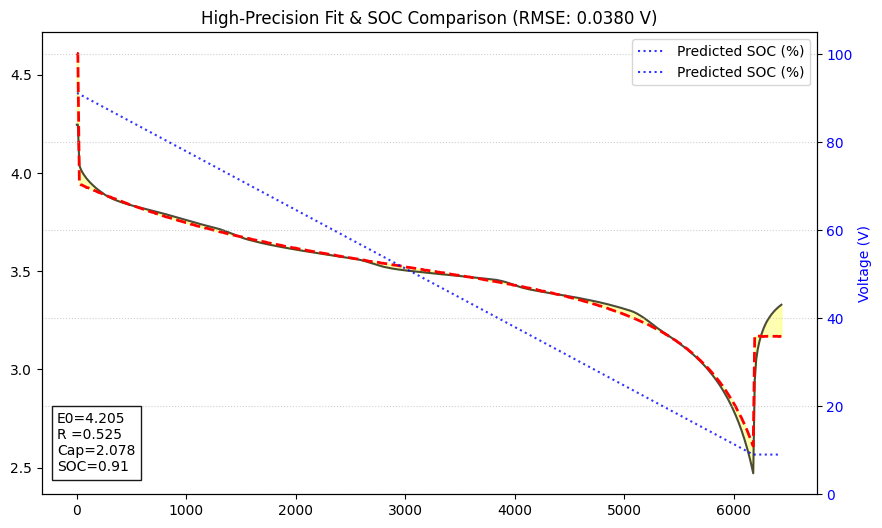

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize,differential_evolution
from BatteryV3 import *
import matplotlib.pyplot as plt

# ==========================================
# 2. 数据加载与预处理
# ==========================================
try:
    df = pd.read_csv(r'C:\Users\lenovo\Desktop\archive\cleaned_dataset\discharge\1.csv')
    print("已加载数据。")
except:
    print("未找到文件，生成测试数据...")
    df = pd.DataFrame({'Time': np.linspace(0,3600,100), 'Voltage_measured': np.linspace(4.2,3.2,100), 'Current_measured': [-1.0]*100, 'Temperature_measured': [24.0]*100})

time_data = df['Time'].values
current_data = -df['Current_measured'].values # 修正符号
voltage_data = df['Voltage_measured'].values
temp_data = df['Temperature_measured'].values
dt_data = np.zeros_like(time_data)
dt_data[1:] = np.diff(time_data)
dt_data[0] = dt_data[1] if len(dt_data) > 1 else 1.0

# ==========================================
# 3. 优化核心逻辑
# ==========================================
def run_sim(params):
    # Unpack params
    p_E0, p_R, p_K, p_A, p_B, p_Cap, p_InitSOC = params
    
    batt = PhysicsBattery(design_capacity_ah=p_Cap, initial_soc=p_InitSOC, initial_temp_c=temp_data[0])
    batt.E0 = p_E0
    batt.R_base = p_R
    batt.K = p_K
    batt.A_vol = p_A
    batt.B_vol = p_B

    
    v_list = []
    t_env = temp_data[0]
    
    # Fast loop
    for i in range(len(time_data)):
        v = batt.step(current_data[i], dt_data[i], temp_env_c=t_env)
        v_list.append(v)
    return np.array(v_list)

def loss_func(params):
    # 物理约束惩罚
    if params[5] <= 0.1: return 1e6 # Capacity
    if params[0] < 2.0: return 1e6 # E0
    
    try:
        sim_res = run_sim(params)
        sim_v = sim_res[:, 0]  # <--- 关键修改：只取第一列电压
        
        mask = ~np.isnan(sim_v)
        if np.sum(mask) < len(sim_v) * 0.9: return 1e6
        
        # 现在 sim_v[mask] 和 voltage_data[mask] 都是 (N,) 维度，可以相减了
        mse = np.mean((sim_v[mask] - voltage_data[mask])**2)
        return np.sqrt(mse)
    except:
        return 1e6

# ==========================================
# 4. 两阶段优化策略
# ==========================================

# --- 阶段 1: 扩大范围的全局搜索 ---
# 我们大幅放宽了边界，尤其是 R 和 E0
bounds_wide = [
    (3.2, 4.5),    # E0: 允许更低的 OCV (有些老化电池 OCV 很低)
    (0.001, 0.5),  # R_base: 允许非常大的内阻 (1欧姆对于老化电池是可能的)
    (0.0, 0.1),    # K
    (0.0, 2.0),    # A_vol: 允许更大的初始电压降
    (0.1, 20.0),   # B_vol: 允许更陡峭的指数曲线
    (1.0, 3.0),    # Capacity
    (0.99, 1.0)    # Init SOC: 允许电池从半电开始

]


print(">>> 阶段 1: 全局搜索 (Differential Evolution)...")
result_stage1 = differential_evolution(
    loss_func, 
    bounds_wide, 
    strategy='best1bin', 
    maxiter=30, 
    popsize=15, 
    tol=0.05, 
    disp=True
)
print(f"阶段 1 完成. RMSE: {result_stage1.fun:.5f} V")

# --- 阶段 2: 局部精细微调 ---
print("\n>>> 阶段 2: 局部微调 (Nelder-Mead)...")
# 使用阶段 1 的结果作为起点
result_stage2 = minimize(
    loss_func, 
    result_stage1.x, 
    method='Nelder-Mead', 
    tol=1e-5,
    options={'maxiter': 500, 'disp': True}
)

final_params = result_stage2.x
print(f"\n最终优化完成! RMSE: {result_stage2.fun:.5f} V")
print("最佳参数:", final_params)

# ==========================================
# 5. 绘图与误差分析 (修正版：包含自动计算的参考 SOC)
# ==========================================
# 1. 运行最终模拟并拆分结果
sim_res_final = run_sim(final_params)
sim_final_v = sim_res_final[:, 0]    # 提取模型预测电压
sim_final_soc = sim_res_final[:, 1]  # 提取模型预测 SOC

# --- 新增内容：基于库仑计数法计算“参考 SOC” (Ground Truth) ---
# 使用优化出的容量 (final_params[5]) 和初始 SOC (final_params[6]) 作为计算基准
opt_cap_ah = final_params[5]
opt_init_soc = final_params[6]

# 计算每一时刻消耗的库仑量 (安培·秒)
# current_data 已经是正值（放电），dt_data 是步长
discharged_coulombs = np.cumsum(current_data * dt_data) 
# 计算参考 SOC 轨迹
ref_soc_coulomb = opt_init_soc - (discharged_coulombs / (opt_cap_ah * 3600))
# -------------------------------------------------------

plt.figure(figsize=(10, 6))

# 2. 画出真实电压数据
plt.plot(time_data, voltage_data, 'k-', linewidth=1.5, alpha=0.7, label='Measured Voltage')

# 3. 画出模拟的电压数据 (使用修正后的 sim_final_v)
plt.plot(time_data, sim_final_v, 'r--', linewidth=2, label='Fitted Model (Voltage)')

# 4. 标注误差区域
plt.fill_between(time_data, voltage_data, sim_final_v, color='yellow', alpha=0.3, label='Error Area')

# 5. 设置双 Y 轴来显示 SOC 变化
ax2 = plt.gca().twinx()

# 画出模型内部 KiBaM 动力学计算的 SOC (蓝色点线)
ax2.plot(time_data, sim_final_soc * 100, 'b:', alpha=0.8, label='Predicted SOC (%)')

# 画出通过库仑计数法计算出的“参考 SOC” (绿色虚线)
# 这代表了基于电流积分的电荷平衡，是模型应当对齐的目标
#ax2.plot(time_data, ref_soc_coulomb * 100, 'g--', linewidth=1.5, alpha=0.8, label='Reference SOC (%)')

ax2.set_ylabel('State of Charge (%)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0, 105)

plt.title(f'High-Precision Fit & SOC Comparison (RMSE: {result_stage2.fun:.4f} V)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')

# 合并两个轴的图例
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='upper right')

plt.grid(True, linestyle=':', alpha=0.6)

# 打印最终优化参数
param_str = (
    f"E0={final_params[0]:.3f}\n"
    f"R ={final_params[1]:.3f}\n"
    f"Cap={final_params[5]:.3f}\n"
    f"SOC={final_params[6]:.2f}"
)
plt.text(0.02, 0.05, param_str, transform=plt.gca().transAxes, 
          bbox=dict(facecolor='white', alpha=0.9))

plt.savefig('final_best_fit.png')
print("图像已保存至 final_best_fit.png")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from BatteryV3 import *

# 1. 初始化模型（带入你拟合出的最优参数）

battery = PhysicsBattery() 

def run_continuous_simulation(model, file_path):
    """
    运行单个数据文件并更新模型状态
    """
    df = pd.read_csv(file_path)
    df['dt'] = df['Time'].diff().fillna(0)
    
    v_preds = []
    soc_preds = []
    
    for _, row in df.iterrows():
        # 注意：在你的数据中，放电电流通常记录为负值
        # 我们的模型 step 函数定义：正值为放电，负值为充电
        # 因此输入电流取反：-row['Current_measured']
        v, s = model.step(-row['Current_measured'], row['dt'], temp_env_c=row['Temperature_measured'])
        v_preds.append(v)
        soc_preds.append(s)
    
    df['V_pred'] = v_preds
    df['SOC_pred'] = soc_preds
    return df

# --- 步骤 1: 运行第一次放电 (00001) ---
# 这一步会让模型从全新的状态演化到放电结束的状态
print("正在同步第一次放电状态...")
df1 = run_continuous_simulation(battery, r'C:\Users\lenovo\Desktop\archive\cleaned_dataset\data\00001.csv')

# --- 步骤 2: 运行中间的充电过程 (00003) ---
# 关键：不重置模型，直接喂入充电电流数据
print("正在同步充电过程中的电荷恢复与老化...")
df3 = run_continuous_simulation(battery, r'C:\Users\lenovo\Desktop\archive\cleaned_dataset\data\00003.csv')
# 假设你的代码已经依次运行了 df1, df3 的模拟
# ... (运行 df1, df3 的循环) ...

# 输出 File 00003 结束瞬间的详细状态
print("--- File 00003 (充电结束) 状态检查 ---")
print(f"当前可用电荷 y1: {battery.y1:.4f} C")
print(f"当前束缚电荷 y2: {battery.y2:.4f} C")
print(f"总电荷 (y1 + y2): {battery.y1 + battery.y2:.4f} C")
print(f"设计总电容 (Capacity): {battery.capacity_design_c:.4f} C")

# 计算物理 SOC
physical_soc = (battery.y1 + battery.y2) / battery.capacity_design_c
print(f"物理荷电状态 (SOC): {physical_soc * 100:.2f}%")

# 检查是否溢出
if (battery.y1 + battery.y2) > battery.capacity_design_c:
    print("⚠️ 警告：检测到充电过头！总电荷超过了设计容量。")
    print(f"溢出量: {(battery.y1 + battery.y2) - battery.capacity_design_c:.2f} C")


    
df5 = run_continuous_simulation(battery, r'C:\Users\lenovo\Desktop\archive\cleaned_dataset\data\00005.csv')

# --- 验证与可视化 ---
plt.figure(figsize=(10, 5))
plt.plot(df5['Time'], df5['Voltage_measured'], 'k--', label='Actual (Measured)')
plt.plot(df5['Time'], df5['V_pred'], 'r-', label='Predicted (with History)')
plt.title('Prediction of 2nd Discharge based on 1st Discharge & Charge History')
plt.legend()
plt.show()

In [ ]:
df6 = run_continuous_simulation(battery, r'C:\Users\lenovo\Desktop\archive\cleaned_dataset\data\00006.csv')

df7 = run_continuous_simulation(battery, r'C:\Users\lenovo\Desktop\archive\cleaned_dataset\data\00007.csv')

# --- 验证与可视化 ---
plt.figure(figsize=(10, 5))
plt.plot(df7['Time'], df7['Voltage_measured'], 'k--', label='Actual (Measured)')
plt.plot(df7['Time'], df7['V_pred'], 'r-', label='Predicted (with History)')
plt.title('Prediction of 2nd Discharge based on 1st Discharge & Charge History')
plt.legend()
plt.show()